In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [11]:
#Encoder
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, z_dim)  # Log variance

    def forward(self, x):
        hidden = torch.relu(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(0.5 * self.fc22(hidden))  # Convert to std dev
        return z_loc, z_scale

#Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)

    def forward(self, z):
        hidden = torch.relu(self.fc1(z))
        loc_img = torch.sigmoid(self.fc2(hidden))  # Pixel probabilities
        return loc_img

In [24]:
class VAE(nn.Module):
    def __init__(self, z_dim=20, hidden_dim=400):  
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # Prior distribution
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # Decode the latent variable z
            loc_img = self.decoder(z)
            
            # Likelihood
            pyro.sample("obs", 
                       dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                       obs=x.reshape(-1, 784))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        with torch.no_grad():
            z_loc, z_scale = self.encoder(x)
            z = dist.Normal(z_loc, z_scale).sample()
            return self.decoder(z)

In [28]:
#Hyperparameters
lr = 0.001 
batch_size = 128
epochs = 20  
z_dim = 20
hidden_dim = 400

#Load the data
train_data = datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

# Model setup
vae = VAE(z_dim=z_dim, hidden_dim=hidden_dim)
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        loss = svi.step(data)
        epoch_loss += loss / len(data)
        
    print(f"Epoch {epoch+1}/{epochs} \tLoss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20 	Loss: 165.1059
Epoch 2/20 	Loss: 122.1062
Epoch 3/20 	Loss: 114.7257
Epoch 4/20 	Loss: 111.5740
Epoch 5/20 	Loss: 109.7311
Epoch 6/20 	Loss: 108.5243
Epoch 7/20 	Loss: 107.6778
Epoch 8/20 	Loss: 107.0245
Epoch 9/20 	Loss: 106.4881
Epoch 10/20 	Loss: 106.0681
Epoch 11/20 	Loss: 105.6996
Epoch 12/20 	Loss: 105.4235
Epoch 13/20 	Loss: 105.0980
Epoch 14/20 	Loss: 104.9285
Epoch 15/20 	Loss: 104.6689
Epoch 16/20 	Loss: 104.5083
Epoch 17/20 	Loss: 104.2893
Epoch 18/20 	Loss: 104.1419
Epoch 19/20 	Loss: 103.9752
Epoch 20/20 	Loss: 103.8649


In [47]:
#Reconstruction:
test_sample = next(iter(train_loader))[0][0].view(1, 784)
reconstructed = vae.reconstruct_img(test_sample)

In [49]:
reconstructed.shape

torch.Size([1, 784])

In [55]:
next(iter(train_loader))[0][0].shape

torch.Size([1, 28, 28])

In [76]:
next(iter(train_loader))[0].shape

torch.Size([128, 1, 28, 28])

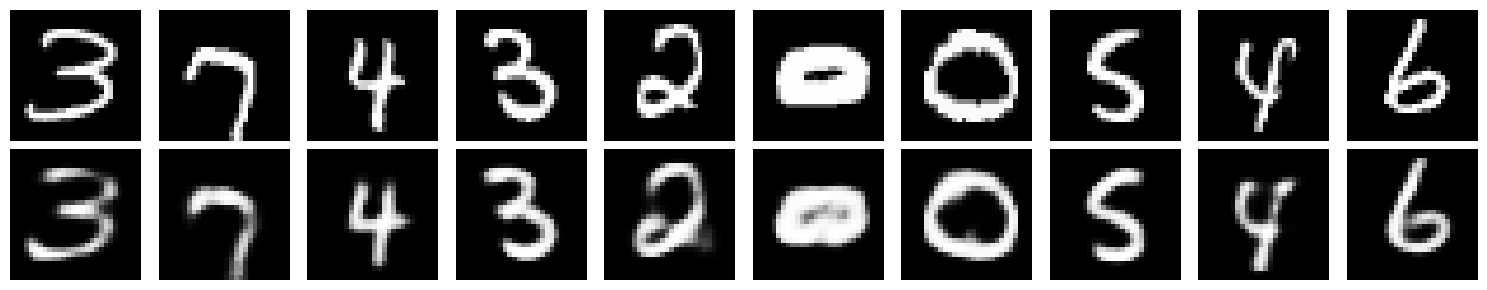

In [91]:
import matplotlib.pyplot as plt

with torch.no_grad():
    data, _ = next(iter(train_loader))
    x = data[:10] 
    x_flat = x.view(-1, 784)
    x_hat = vae.reconstruct_img(x_flat)
    
    x = x.view(-1, 28, 28)   
    x_hat = x_hat.view(-1, 28, 28)

    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(x[i].numpy(), cmap='gray')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(x_hat[i].numpy(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [107]:
torch.min(x)

tensor(0.)